In [1]:
%matplotlib widget
import os
import matplotlib.pyplot as plt
import numpy as np
import pyobs
# from scipy.stats import norm
import bison

%load_ext autoreload
%autoreload 1

%aimport Bounding_Method

# plt.rcParams.update({
#     "text.usetex"      : True,
#     "font.family"      : "Helvetica",
#     "mathtext.fontset" : "dejavuserif"
# })
plt.rcParams.update({
    "axes.axisbelow"   : True,
})

In [2]:
### Loading data file ###
data = bison.load("Cnfgs_measurement/WF-slices_beta617_seed123456.dat")

[Bison] : Reading file Cnfgs_measurement/WF-slices_beta617_seed123456.dat
[Bison] : File created by gmorandi at ampere on Tue Dec 19 00:02:04 2023
[Bison] : Read 278.455 MB at 110.37 MB/s


In [3]:
##############################
### General run parameters ###
##############################
beta      =  data['beta coupling']
L1, L2, L3, T = data['Lattice']
V         =  L1 * L2 * L3 * T
D         =  4
Ns        =  data['Number of steps of OMF4 integrator']
tauMD     =  data['Length of each MD trajectory']
Ntraj     =  data['MD trajectories']
MC_step   =  data['MC measure step']
eps_WF    =  data['epsilon WF']
WF_evol   =  data['WF evolutions from t = 0']
WF_step   =  data['WF measure step']
Nwf       =  WF_evol // WF_step + 1
Nc_run    = Ntraj // MC_step

Ncnfg0 = 0
Nh     = 0
for key in data:
    if key.startswith('Configuration'):
        Ncnfg0 += 1
    if key.startswith('MC History'):
        Nh += 1


print(f"\n Lattice                =  [{L1}x{L2}x{L3}x{T}]")
print(f" Lattice volume         =  {V}")
print(f" beta                   =  {beta}")
print(f" Steps of OMF4          =  {Ns}")
print(f" tau MD                 =  {tauMD}")
print(f" MD trajectories        =  {Ntraj}")
print(f" MC interval between measurements  =  {MC_step}")
print(f" epsilon of Wilson Flow =  {eps_WF}")
print(f" Wilson Flow evolutions =  {WF_evol}")
print(f" Wilson Flow steps between measurements =  {WF_step}\n")

print(f" Measured flow times:")
print(f" from t = {eps_WF * WF_step * 0:.2f} to t = {eps_WF * WF_step * (Nwf - 1):.2f}")
print(f" total measurements in flow time = {Nwf}")

Ntherm0 = 200
print(f"\n Total number of measurements = {Ncnfg0}, extracted from {Nh} runs, {Nc_run} meas. each.")
print(f" Total number of configurations = {int(Ncnfg0 * tauMD * MC_step)} MDU")
print(f" Preliminary thermalization trajectories = {Ntherm0}, i.e. {int(Ntherm0 * tauMD)} MDU")
print(f" we should reach 5 x max(tau_int) [MDU], namely ~ {int(5 * MC_step * tauMD * 20)} MDU")
print(f" so we skip {(5 * 20 * MC_step - Ntherm0)*int(tauMD)} MDUs in the current initial data.\n")
skip = (5 * 20 * MC_step - Ntherm0) // MC_step
print(f" In other words we have to skip {skip} measurements.")

Ncnfg = Ncnfg0 - skip
print(f" Total configs. = {Ncnfg} (after removing initial due to therm.)")


 Lattice                =  [32x32x32x64]
 Lattice volume         =  2097152
 beta                   =  6.17
 Steps of OMF4          =  8
 tau MD                 =  2.0
 MD trajectories        =  200
 MC interval between measurements  =  10
 epsilon of Wilson Flow =  0.02
 Wilson Flow evolutions =  300
 Wilson Flow steps between measurements =  5

 Measured flow times:
 from t = 0.00 to t = 6.00
 total measurements in flow time = 61

 Total number of measurements = 3100, extracted from 155 runs, 20 meas. each.
 Total number of configurations = 62000 MDU
 Preliminary thermalization trajectories = 200, i.e. 400 MDU
 we should reach 5 x max(tau_int) [MDU], namely ~ 2000 MDU
 so we skip 1600 MDUs in the current initial data.

 In other words we have to skip 80 measurements.
 Total configs. = 3020 (after removing initial due to therm.)


In [4]:
########################################################
### Loading history run and observables measurements ###
########################################################
WF_EClov = np.zeros((Ncnfg0, Nwf, T))
WF_Plaq  = np.zeros((Ncnfg0, Nwf, T))
WF_Q     = np.zeros((Ncnfg0, Nwf, T))
Acc      = np.zeros((Nh * Ntraj)) 
dH       = np.zeros((Nh * Ntraj))

for i in range(Ncnfg0):
    WF_EClov[i,:,:] = data[f'Configuration {i+1}']['E_Clov']
    WF_Plaq[i,:,:]  = data[f'Configuration {i+1}']['Plaquette']
    WF_Q[i,:,:]     = data[f'Configuration {i+1}']['Q'] 

for i in range(Nh):
    Acc[i*Ntraj:(i+1)*Ntraj] = data[f'MC History tag-{i}']['Acc/Rej']
    dH[i*Ntraj:(i+1)*Ntraj]  = data[f'MC History tag-{i}']['dH']

print(f"\n Acceptance rate        =  {np.mean(Acc)*100:.0f} %")
print(f" < |dH| >               =  {np.mean(np.abs(dH)):.3e}\n")

t_WF = np.array([eps_WF * WF_step * i for i in range(Nwf)])


 Acceptance rate        =  95 %
 < |dH| >               =  1.087e-01



In [5]:
### Compute <E>_Clov and tau_int for several Wilson flow times ###
EClov_t = []
EClov   = []
for i0 in range(Nwf):
    EClov_t.append(pyobs.observable(description=f'<E(t)>_Clov at tWF = {t_WF[i0]:.2f}'))
    EClov_t[-1].create('Ensemble A', (WF_EClov[skip:,i0,:] * T/V).flatten(), shape=(T,)) 
    EClov.append(pyobs.sum(EClov_t[-1]) / T)
    print(f"(t = {t_WF[i0]:.2f}) :    <E(t)>_Clov = {EClov_t[-1]}                   <E>_Clov = {EClov[-1]}                    tau_int = {EClov[-1].tauint()['Ensemble A'][0][0]:.3f} +- \
{EClov[-1].tauint()['Ensemble A'][1][0]:.3f}\n")
##################################################################

(t = 0.00) :    <E(t)>_Clov = 1.955250(61)	1.955295(63)	1.955434(59)	1.955393(57)	1.955369(58)	1.955409(62)	1.955401(58)	1.955252(57)	1.955272(58)	1.955363(61)	1.955395(58)	1.955410(63)	1.955254(58)	1.955316(56)	1.955391(61)	1.955286(66)	1.955342(61)	1.955309(61)	1.955365(61)	1.955338(61)	1.955270(61)	1.955343(58)	1.955362(58)	1.955275(61)	1.955337(60)	1.955323(59)	1.955315(57)	1.955396(60)	1.955308(62)	1.955316(60)	1.955207(62)	1.955192(58)	1.955201(59)	1.955264(58)	1.955267(59)	1.955325(58)	1.955203(56)	1.955178(63)	1.955263(59)	1.955268(58)	1.955230(61)	1.955326(59)	1.955233(59)	1.955253(58)	1.955350(63)	1.955245(59)	1.955280(58)	1.955277(60)	1.955237(58)	1.955300(61)	1.955253(58)	1.955385(62)	1.955317(61)	1.955398(57)	1.955415(60)	1.955359(59)	1.955299(65)	1.955331(61)	1.955363(62)	1.955369(65)	1.955319(65)	1.955383(55)	1.955279(58)	1.955321(61)
                   <E>_Clov = 1.955312(11)
                    tau_int = 0.614 +- 0.050

(t = 0.10) :    <E(t)>_Clov = 1.373025(70)	1.3730

In [6]:
### Compute <Plaq>, <E>_Plaq and tau_int for several Wilson flow times ###
Plaq_t  = []
EPlaq_t = []
Plaq    = []
EPlaq   = []
for i0 in range(Nwf):
    Plaq_t.append(pyobs.observable(description=f'<Plaq(t)> at t_WF = {t_WF[i0]:.2f}'))
    Plaq_t[-1].create('Ensemble A', (WF_Plaq[skip:,i0,:] * T/V).flatten(), shape=(T,))
    Plaq.append(pyobs.sum(Plaq_t[-1]) / T)
    EPlaq_t.append(beta * (1 - Plaq_t[-1]) * D * (D-1) / 2)
    EPlaq.append(pyobs.sum(EPlaq_t[-1]) / T)
    print(f"(t = {t_WF[i0]:.2f}) :    <Plaq(t)> = {Plaq_t[-1]}                   <Plaq> = {Plaq[-1]}              <E(t)>_Plaq = {EPlaq_t[-1]}\
                 <E>_Plaq = {EPlaq[-1]}                  tau_int = {EPlaq[-1].tauint()['Ensemble A'][0][0]:.3f} +- {EPlaq[-1].tauint()['Ensemble A'][1][0]:.3f}\n")
##########################################################################

(t = 0.00) :    <Plaq(t)> = 0.610884(11)	0.610865(10)	0.610836(10)	0.610844(11)	0.610868(11)	0.610852(11)	0.610853(11)	0.610852(12)	0.610866(11)	0.610865(11)	0.610867(11)	0.610860(12)	0.610897(11)	0.610872(10)	0.610855(10)	0.610871(11)	0.610867(12)	0.610867(11)	0.610875(10)	0.610865(10)	0.610858(11)	0.610874(10)	0.610867(11)	0.610848(12)	0.610879(11)	0.610862(11)	0.610849(10)	0.610857(11)	0.610876(11)	0.610873(11)	0.610887(11)	0.610876(10)	0.610869(11)	0.610885(11)	0.610865(11)	0.610874(11)	0.610879(11)	0.610864(11)	0.610868(11)	0.610858(10)	0.610886(10)	0.610861(11)	0.610886(11)	0.610857(12)	0.610851(11)	0.610876(11)	0.610865(11)	0.610873(11)	0.610867(10)	0.610862(11)	0.610881(11)	0.610867(10)	0.610860(11)	0.610845(11)	0.610857(11)	0.610867(11)	0.610853(11)	0.610862(11)	0.610866(11)	0.610861(11)	0.610873(11)	0.610851(10)	0.610879(11)	0.610868(11)
                   <Plaq> = 0.6108659(16)
              <E(t)>_Plaq = 14.40506(40)	14.40578(39)	14.40686(38)	14.40654(39)	14.40566(40)	14.40

In [7]:
### Compute <Q(t)>, <Q> and tau_int for several Wilson flow times ###
Q_t = []
Q   = []
for i0 in range(Nwf):
    Q_t.append(pyobs.observable(description=f'<Q(t)> at t_WF = {t_WF[i0]:.2f}'))
    Q_t[-1].create('Ensemble A', (WF_Q[skip:,i0,:] * T/V).flatten(), shape=(T,))
    Q.append(pyobs.sum(Q_t[-1]) / T)
    print(f"(t = {t_WF[i0]:.2f}) :    <Q(t)> = {Q_t[-1]}                   <Q> = {Q[-1]}               tau_int = {Q[-1].tauint()['Ensemble A'][0][0]:.3f} +- \
{Q[-1].tauint()['Ensemble A'][1][0]:.3f}\n")
#####################################################################

(t = 0.00) :    <Q(t)> = 1.6(1.1)	-0.7(1.1)	0.2(1.0)	0.7(1.1)	1.1(1.1)	-0.2(1.0)	-1.1(1.1)	-0.0(1.1)	-0.3(1.2)	1.4(1.0)	-1.6(1.0)	0.0(1.0)	-0.5(1.0)	-2.4(1.2)	0.4(1.1)	0.2(1.2)	-0.2(1.1)	1.5(1.0)	0.6(1.1)	1.2(1.1)	-0.8(1.1)	-0.2(1.1)	0.3(1.1)	1.1(1.1)	0.9(1.1)	0.1(1.1)	0.6(1.1)	-1.4(1.1)	0.8(1.2)	0.7(1.2)	0.1(1.1)	0.4(1.1)	-1.3(1.1)	0.1(1.1)	0.0(1.1)	-1.8(1.1)	-0.6(1.0)	-0.7(1.0)	-2.5(1.1)	-1.4(1.1)	-0.1(1.1)	-2.2(1.1)	-1.7(1.1)	0.2(1.1)	-1.8(1.1)	2.2(1.2)	-2.7(1.1)	-1.0(1.1)	-0.4(1.1)	1.4(1.1)	-1.6(1.1)	1.6(1.1)	0.8(1.1)	-0.5(1.1)	0.2(1.1)	-1.3(1.1)	-1.7(1.0)	-0.7(1.0)	0.84(99)	-0.2(1.1)	1.7(1.1)	1.0(1.1)	-1.2(1.1)	0.3(1.2)
                   <Q> = -0.16(14)
               tau_int = 0.684 +- 0.056

(t = 0.10) :    <Q(t)> = 2.2(1.0)	-0.3(1.0)	0.3(1.1)	0.9(1.0)	1.4(1.0)	0.60(99)	-0.5(1.1)	0.4(1.1)	-0.6(1.1)	-0.07(99)	-2.01(97)	0.38(95)	-0.58(98)	-2.7(1.1)	0.6(1.0)	0.8(1.1)	-0.32(98)	1.96(99)	0.46(99)	0.3(1.0)	-1.0(1.1)	-1.1(1.1)	0.5(1.0)	1.7(1.0)	1.68(97)	-0.03(98)	0.9(1.1)	-1.2(1.0)	1.

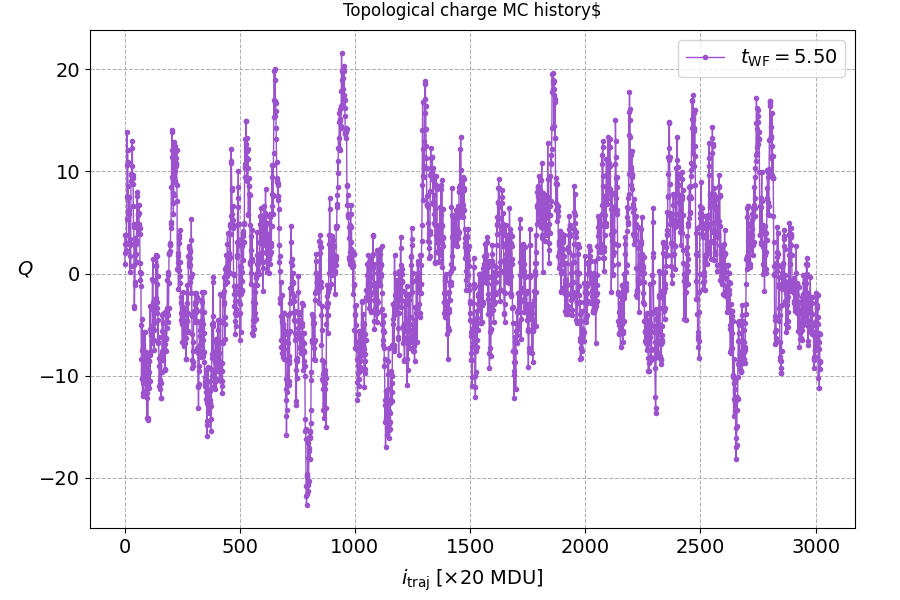

In [8]:
### MC history of Q for several tWF ###

fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.10)
plt.subplots_adjust(right  = 0.95)

fsize = 14

ax.set_title(f"Topological charge MC history$", pad=10)
ax.set_ylabel(r"$Q$", labelpad=10, rotation=0, fontsize=fsize)
ax.set_xlabel(rf'$i_{{\mathrm{{traj}}}} \; [\times {int(MC_step * tauMD)} \; \mathrm{{MDU}}]$', labelpad=8, fontsize=fsize)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
ax.grid(linestyle = '--', linewidth = 0.75)
#plt.xlim([1750, 1840])
#plt.ylim([1e-2, 1e1])

t0 = 5.50
i0 = int(np.around(t0 / (eps_WF * WF_step)))
ax.plot(np.arange(1, Ncnfg+1), np.sum(WF_Q[skip:, i0, :], axis=1)/V, label=rf'$t_{{\mathrm{{WF}}}} = {t0:.2f}$', linestyle='-', marker='o' , markersize=3.0, color='#9b52cc', linewidth=1.0)

ax.legend(loc='best', fontsize=fsize)
#plt.savefig("tau_int.pdf")

[-20.5 -19.5 -18.5 -17.5 -16.5 -15.5 -14.5 -13.5 -12.5 -11.5 -10.5  -9.5
  -8.5  -7.5  -6.5  -5.5  -4.5  -3.5  -2.5  -1.5  -0.5   0.5   1.5   2.5
   3.5   4.5   5.5   6.5   7.5   8.5   9.5  10.5  11.5  12.5  13.5  14.5
  15.5  16.5  17.5  18.5  19.5  20.5]


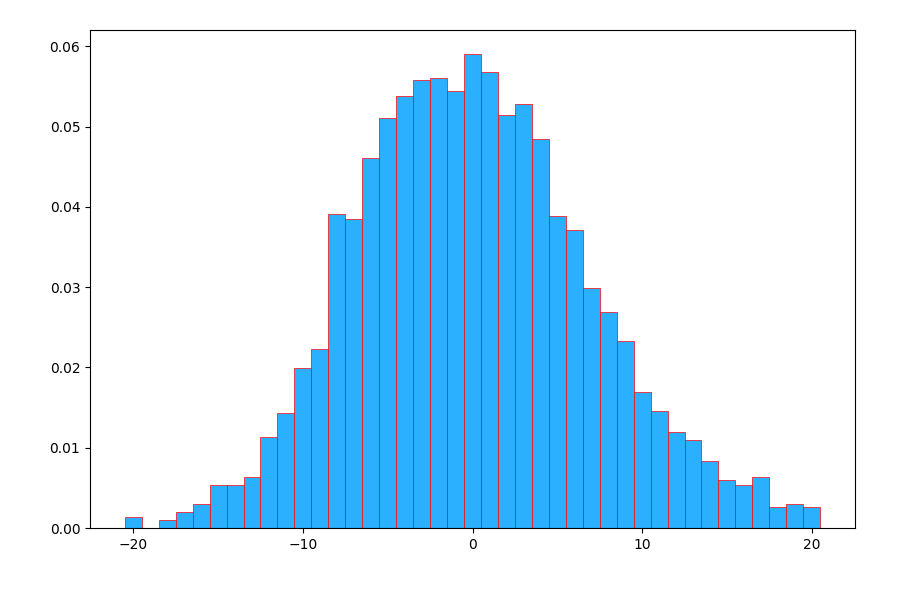

In [9]:
fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.10)
plt.subplots_adjust(right  = 0.95)

t0 = 5.50
i0 = int(np.around(t0 / (eps_WF * WF_step)))

binwidth = 1.0
data = (np.sum(WF_Q[skip:,i0,:], axis=1)/V).copy()
counts, bins, obj = ax.hist(data, density=True, bins=np.arange(-20.5, 20.5 + binwidth, binwidth), facecolor = '#2ab0ff', edgecolor='red', linewidth=0.5)
print(bins)

# mu, sigma = norm.fit(np.sum(WF_Q[Ntherm0:,i0,:], axis=1)/V)
# best_fit_line = norm.pdf(bins, mu, sigma)
# plt.plot(bins, best_fit_line)
# print(mu, np.sqrt(sigma))

In [10]:
### Compute <Q^2> and tau_int for several Wilson flow times ###
dQ = np.zeros((Nwf, Ncnfg))
Q2       = []
for i0 in range(Nwf):
    dQ[i0, :] = Q[i0].delta['Ensemble A:0'].delta.reshape(Ncnfg)
    Q2.append(pyobs.observable(description=f'<Q^2> at t_WF = {t_WF[i0]:.2f}'))
    Q2[-1].create('Ensemble A', (dQ[i0,:]**2).flatten(), shape=(1,))
    print(f"(t = {t_WF[i0]:.2f}) :    <Q^2> = {Q2[-1]}              tau_int = {Q2[-1].tauint()['Ensemble A'][0][0]:.3f} +- \
{Q2[-1].tauint()['Ensemble A'][1][0]:.3f}\n")
###############################################################

(t = 0.00) :    <Q^2> = 41.9(1.1)
              tau_int = 0.537 +- 0.039

(t = 0.10) :    <Q^2> = 25.05(82)
              tau_int = 0.843 +- 0.075

(t = 0.20) :    <Q^2> = 22.0(1.7)
              tau_int = 4.504 +- 0.836

(t = 0.30) :    <Q^2> = 25.2(2.4)
              tau_int = 6.516 +- 1.403

(t = 0.40) :    <Q^2> = 29.1(2.9)
              tau_int = 7.180 +- 1.611

(t = 0.50) :    <Q^2> = 32.3(3.3)
              tau_int = 7.449 +- 1.693

(t = 0.60) :    <Q^2> = 34.8(3.6)
              tau_int = 7.614 +- 1.730

(t = 0.70) :    <Q^2> = 36.6(3.8)
              tau_int = 7.591 +- 1.747

(t = 0.80) :    <Q^2> = 38.0(3.9)
              tau_int = 7.628 +- 1.756

(t = 0.90) :    <Q^2> = 39.1(4.0)
              tau_int = 7.642 +- 1.759

(t = 1.00) :    <Q^2> = 40.0(4.1)
              tau_int = 7.643 +- 1.759

(t = 1.10) :    <Q^2> = 40.7(4.2)
              tau_int = 7.637 +- 1.758

(t = 1.20) :    <Q^2> = 41.3(4.3)
              tau_int = 7.629 +- 1.756

(t = 1.30) :    <Q^2> = 41.9(4.3)
    

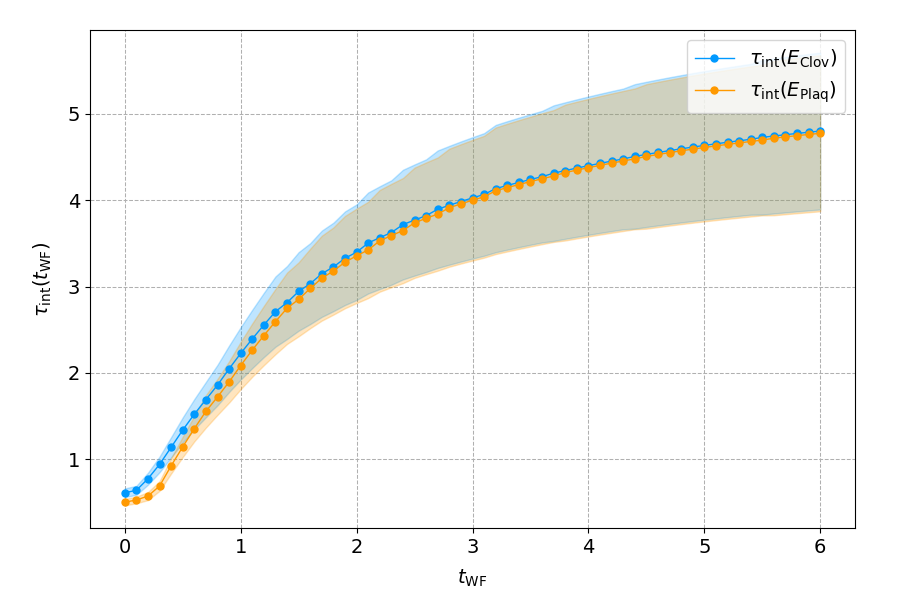

In [11]:
tau_EClov = np.array([np.squeeze(EClov[i0].tauint()['Ensemble A'], axis=1) for i0 in range(Nwf)])
tau_EPlaq = np.array([np.squeeze(EPlaq[i0].tauint()['Ensemble A'], axis=1) for i0 in range(Nwf)])
tau_Q     = np.array([np.squeeze(Q[i0].tauint()['Ensemble A'],     axis=1) for i0 in range(Nwf)])
tau_Q2    = np.array([np.squeeze(Q2[i0].tauint()['Ensemble A'],    axis=1) for i0 in range(Nwf)])


fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.10)
plt.subplots_adjust(right  = 0.95)

fsize = 14

ax.set_ylabel(r"$\tau_\mathrm{int}(t_\mathrm{WF})$", labelpad=10, rotation=90, fontsize=fsize)
ax.set_xlabel(r'$t_\mathrm{WF}$', labelpad=8, fontsize=fsize)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
#plt.xlim([-1, 50.5])
#plt.ylim([1e-2, 1e1])
ax.grid(linestyle = '--', linewidth = 0.75)

std = 1.0
ax.plot(t_WF, tau_EClov[:,0], label=r'$\tau_\mathrm{int}(E_\mathrm{Clov})$', linestyle='-', marker='o' , markersize=5.0, color='#0099ff', linewidth=1.0)
ax.fill_between(t_WF, tau_EClov[:,0] + std * tau_EClov[:,1], tau_EClov[:,0] - std * tau_EClov[:,1], alpha=.25, color='#0099ff')
ax.plot(t_WF, tau_EPlaq[:,0], label=r'$\tau_\mathrm{int}(E_\mathrm{Plaq})$', linestyle='-', marker='o' , markersize=5.0, color='#ff9900', linewidth=1.0)
ax.fill_between(t_WF, tau_EPlaq[:,0] + std * tau_EPlaq[:,1], tau_EPlaq[:,0] - std * tau_EPlaq[:,1], alpha=.25, color='#ff9900')
# ax.plot(t_WF, tau_Q[:,0], label=r'$\tau_\mathrm{int}(Q)$', linestyle='-', marker='o' , markersize=5.0, color='#a151bf', linewidth=1.0)
# ax.fill_between(t_WF, tau_Q[:,0] + std * tau_Q[:,1], tau_Q[:,0] - std * tau_Q[:,1], alpha=.25, color='#a151bf')
# ax.plot(t_WF, tau_Q2[:,0], label=r'$\tau_\mathrm{int}(Q^2)$', linestyle='-', marker='o' , markersize=5.0, color='#d13e27', linewidth=1.0)
# ax.fill_between(t_WF, tau_Q2[:,0] + std * tau_Q2[:,1], tau_Q2[:,0] - std * tau_Q2[:,1], alpha=.25, color='#d13e27')

ax.legend(loc='best', fontsize=fsize)
#plt.savefig("tau_int.pdf")

In [12]:
### Compute t^2<E> for each t_WF ###
t2EClov = (t_WF[1:]**2) * pyobs.remove_tensor(pyobs.stack(EClov))[1:]
t2EPlaq = (t_WF[1:]**2) * pyobs.remove_tensor(pyobs.stack(EPlaq))[1:]
for i0 in range(Nwf-1):
    print(f"(t = {t_WF[i0+1]:.2f}) :   t^2 * <E>_Clov = {t2EClov[i0]}               t^2 * <E>_Plaq = {t2EPlaq[i0]}\n")

(t = 0.10) :   t^2 * <E>_Clov = 0.01373087(15)
               t^2 * <E>_Plaq = 0.06053996(50)


(t = 0.20) :   t^2 * <E>_Clov = 0.03439706(67)
               t^2 * <E>_Plaq = 0.1047970(15)


(t = 0.30) :   t^2 * <E>_Clov = 0.0493386(15)
               t^2 * <E>_Plaq = 0.1151839(26)


(t = 0.40) :   t^2 * <E>_Clov = 0.0593593(27)
               t^2 * <E>_Plaq = 0.1141953(40)


(t = 0.50) :   t^2 * <E>_Clov = 0.0667000(41)
               t^2 * <E>_Plaq = 0.1116601(56)


(t = 0.60) :   t^2 * <E>_Clov = 0.0726785(58)
               t^2 * <E>_Plaq = 0.1102152(75)


(t = 0.70) :   t^2 * <E>_Clov = 0.0779398(78)
               t^2 * <E>_Plaq = 0.1101580(96)


(t = 0.80) :   t^2 * <E>_Clov = 0.082797(10)
               t^2 * <E>_Plaq = 0.111222(12)


(t = 0.90) :   t^2 * <E>_Clov = 0.087411(13)
               t^2 * <E>_Plaq = 0.113095(15)


(t = 1.00) :   t^2 * <E>_Clov = 0.091870(16)
               t^2 * <E>_Plaq = 0.115532(18)


(t = 1.10) :   t^2 * <E>_Clov = 0.096227(19)
               t^2

In [13]:
### Calculation of t_0 for both E_Clov and E_Plaq ###
eps = 0.01

x, dx = t2EClov.error()
idx_x = np.squeeze(np.where((x < 0.3 + eps) & (x > 0.3 - eps)), axis=0)
print(f"\nE_Clov  :")
print(f"                  E_Clov  =  {x[idx_x]},") 
print(f"                  t_WF    =  {t_WF[idx_x+1]},\n") # recall t_WF starts from 0.0, whose corresponding value is not neither in obs_t2EClov nor in obs_t2EPlaq.
interp_Clov = pyobs.interpolate(t_WF[idx_x+1], t2EClov[idx_x])
t0EClov = interp_Clov.solve(0.3, bracket=[t_WF[(idx_x+1)[0]], t_WF[(idx_x+1)[-1]]])
print(f"                  interpolation  --->  t0/a^2 = {t0EClov}")
if os.path.exists("PyObs/t0EClov.pyobs"):
    os.remove("PyObs/t0EClov.pyobs")
    pyobs.save("PyObs/t0EClov.pyobs", t0EClov)
else:
    pyobs.save("PyObs/t0EClov.pyobs", t0EClov)


y, dy = t2EPlaq.error()
idx_y = np.squeeze(np.where((y < 0.3 + eps) & (y > 0.3 - eps)), axis=0)
print(f"\n\nE_Plaq  :")
print(f"                  E_Plaq  =  {y[idx_y]},") 
print(f"                  t_WF    =  {t_WF[idx_y+1]},\n")
interp_Plaq = pyobs.interpolate(t_WF[idx_y+1], t2EPlaq[idx_y])
t0EPlaq = interp_Plaq.solve(0.3, bracket=[t_WF[(idx_y+1)[0]], t_WF[(idx_y+1)[-1]]])
print(f"                  interpolation  --->  t0/a^2 = {t0EPlaq}")
if os.path.exists("PyObs/t0EPlaq.pyobs"):
    os.remove("PyObs/t0EPlaq.pyobs")
    pyobs.save("PyObs/t0EPlaq.pyobs", t0EPlaq)
else:
    pyobs.save("PyObs/t0EPlaq.pyobs", t0EPlaq)


E_Clov  :
                  E_Clov  =  [0.29470629 0.29997347 0.30527102],
                  t_WF    =  [5.4 5.5 5.6],

                  interpolation  --->  t0/a^2 = 5.5005(71)

[Bison] : Written 0.0275068 MB at 8.29716 MB/s


E_Plaq  :
                  E_Plaq  =  [0.29318846 0.29851947 0.30388516 0.30928523],
                  t_WF    =  [5.  5.1 5.2 5.3],

                  interpolation  --->  t0/a^2 = 5.1277(66)

[Bison] : Written 0.0274487 MB at 9.6004 MB/s


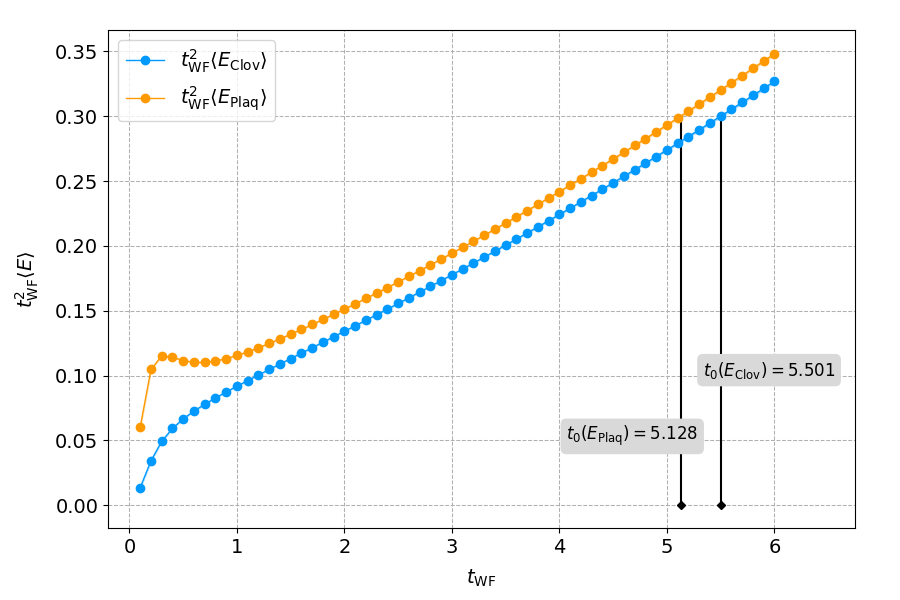

In [14]:
t0_EClov, dt0_EClov = np.squeeze(t0EClov.error(), axis=1)
t0_EPlaq, dt0_EPlaq = np.squeeze(t0EPlaq.error(), axis=1)
t2_EClov = np.array([np.squeeze(t2EClov[i0].error(), axis=1) for i0 in range(Nwf-1)])
t2_EPlaq = np.array([np.squeeze(t2EPlaq[i0].error(), axis=1) for i0 in range(Nwf-1)])

fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.12)
plt.subplots_adjust(right  = 0.95)

fsize = 14
std = 2.0
box = dict(boxstyle="round", color='#d9d9d9')

ax.set_ylabel(r"$t_\mathrm{WF}^2 \langle E \rangle$", labelpad=10, rotation=90, fontsize=fsize)
ax.set_xlabel(r'$t_\mathrm{WF}$', labelpad=8, fontsize=fsize)

ax.vlines(x = t0_EClov, ymin = 0, ymax = 0.3, colors = 'black', linewidth=1.5)
ax.errorbar(t0_EClov, 0.0, xerr=std*dt0_EClov, color='black', marker='D', markersize=4)
ax.annotate(rf"$t_0(E_\mathrm{{Clov}}) = {t0_EClov:.3f}$", (t0_EClov, 0.10), xytext=(t0_EClov+0.45, 0.10), ha='center', bbox=box, fontsize=fsize-2)
ax.vlines(x = t0_EPlaq, ymin = 0, ymax = 0.3, colors = 'black', linewidth=1.5)
ax.errorbar(t0_EPlaq, 0.0, xerr=std*dt0_EPlaq, color='black', marker='D', markersize=4)
ax.annotate(rf"$t_0(E_\mathrm{{Plaq}}) = {t0_EPlaq:.3f}$", (t0_EPlaq, 0.10), xytext=(t0_EPlaq-0.45, 0.05), ha='center', bbox=box, fontsize=fsize-2)


plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.xlim([-0.2, 6.75])
#plt.ylim([1e-2, 1e1])
ax.grid(linestyle = '--', linewidth = 0.75)

ax.plot(t_WF[1:], t2_EClov[:,0], label=r'$t_\mathrm{WF}^2 \langle E_\mathrm{Clov} \rangle$', linestyle='-', marker='o' , markersize=6.0, color='#0099ff', linewidth=1.0)
ax.fill_between(t_WF[1:], t2_EClov[:,0] + std * t2_EClov[:,1], t2_EClov[:,0] - std * t2_EClov[:,1], alpha=.25, color='#0099ff')
ax.plot(t_WF[1:], t2_EPlaq[:,0], label=r'$t_\mathrm{WF}^2 \langle E_\mathrm{Plaq} \rangle$', linestyle='-', marker='o' , markersize=6.0, color='#ff9900', linewidth=1.0)
ax.fill_between(t_WF[1:], t2_EPlaq[:,0] + std * t2_EPlaq[:,1], t2_EPlaq[:,0] - std * t2_EPlaq[:,1], alpha=.25, color='#ff9900')

ax.legend(loc='best', fontsize=fsize)
#plt.savefig('t0E.pdf')

In the python script I measure $\widetilde{q}(t) = \sum_{\mathbf{x}}q(t, \mathbf{x})$ using the function <code>topol_charge(..., field=True)</code> (indeed the function does not include the factor $\times 1/V$). Therefore what we call <b>Topological Charge</b> is
$$
    \langle Q \rangle = \frac{1}{V} \sum_t \langle \widetilde{q}(t) \rangle = \frac{1}{V} \sum_{\mathbf{x}, t} \langle q(t, \mathrm{x}) \rangle = \frac{1}{V} \sum_{\mathbf{x}, t} \langle q(0, \mathrm{0}) \rangle \, ,
$$
where we exploited translational invariance in the third step. Thus, we have to average over all MC configurations, sum over $t$ and divide by $V$ to compute the Topological Charge. 

Similarly, the calculation of the <b>Topological Susceptibility</b> $\chi = \frac{\langle Q^2 \rangle}{V}$ is straightforward
\begin{align*}
    \langle Q^2 \rangle &= \frac{1}{V^2} \sum_{t, t'} \langle \widetilde{q}(t) \widetilde{q}(t') \rangle_c = \frac{1}{V^2} \sum_{t, t'} \sum_{\mathbf{x}, \mathbf{x}'} \langle q(t, \mathrm{x}) q(t', \mathrm{x}') \rangle_c \\
    &= \frac{1}{V^2} \sum_{t, t'} \sum_{\mathbf{x}, \mathbf{z}} \langle q(t, \mathrm{z}) q(0, \mathrm{0}) \rangle_c = \frac{1}{V} \sum_{\mathbf{x}, t} \langle q(t, \mathrm{x}) q(0, \mathrm{0}) \rangle_c \, .
\end{align*}

Equivalently, we can construct an estimator with $T$ more statistics following this procedure. Let's consider the expectation value
$$
    A(t) \equiv \left\langle \frac{1}{T} \sum_{t'} \widetilde{q}(t') \widetilde{q}(t+t') \right\rangle_c = A(t)_\mathrm{conn} + A(t)_\mathrm{disc} \, ;
$$
focusing on its purely connected part we have 
$$
   A(t)_\mathrm{conn} = \frac{1}{T} \sum_{t'} \sum_{\mathbf{x}, \mathbf{y}} \langle q(t', \mathbf{x}) q(t+t', \mathbf{y}) \rangle = \frac{1}{T} \sum_{t'} \sum_{\mathbf{x}, \mathbf{y}} \langle q(t, |\mathbf{x} - \mathbf{y}|) q(0,0) \rangle = \frac{V}{T} \sum_{\mathbf{x}} \langle q(t, \mathbf{x}) q(0,0) \rangle \, ;
$$
therefore 
$$
    \frac{T}{V} A(t)_\mathrm{conn} = \sum_{\mathbf{x}} \langle q(t, \mathbf{x}) q(0,0) \rangle \, ;
$$
similarly, the disconnected term becomes
$$
    A(t)_\mathrm{disc} = \frac{1}{T} \sum_{t'} \sum_{\mathbf{x}, \mathbf{y}} \langle q(t', \mathbf{x}) \rangle \langle q(t+t', \mathbf{y}) \rangle = \frac{1}{T} \sum_{t'} \sum_{\mathbf{x}, \mathbf{y}} \langle q(0,0) \rangle^2 = \frac{V^2}{T^2} \langle q(0,0) \rangle^2 \, .
$$
In other words we obtain
$$
    \langle Q^2 \rangle = \frac{1}{V} \frac{T}{V} \sum_t A(t) = \frac{1}{V} \left\lbrace \sum_{t, \mathbf{x}} \langle q(t, \mathbf{x}) q(0,0) \rangle - \frac{V}{T} \sum_t \langle q(0,0) \rangle^2 \right\rbrace \equiv \sum_t C(t) \, .
$$

In [15]:
###################################################
### Compute correlator <q(t)q(0)> for each t_WF ###
dQ_t   = np.zeros((Nwf, Ncnfg, T))
for i0 in range(Nwf):
    dQ_t[i0,:,:] = Q_t[i0].delta['Ensemble A:0'].delta.T

dQdQ_t = np.zeros((Nwf, Ncnfg, T))
for tp in range(T):
    dQdQ_t[:,:,tp] = np.mean(dQ_t * np.roll(dQ_t, -tp, axis=2), axis=2) 

Corr_QQ = []
for i0 in range(Nwf):
    Corr_QQ.append(pyobs.observable(description=f'<q(t)q(0)>_conn for t_WF = {t_WF[i0]:.2f}'))
    Corr_QQ[-1].create('Ensemble A', dQdQ_t[i0,:,:].flatten(), shape=(T,))
    Corr_QQ[-1] /= T
    print(f"t_WF = {t_WF[i0]:.2f}  :  <q(t)q(0)> = {Corr_QQ[-1]}                     <Q^2> = {pyobs.sum(Corr_QQ[-1])}")
###################################################

t_WF = 0.00  :  <q(t)q(0)> = 54.89(17)	-4.80(12)	-1.26(13)	0.03(12)	0.10(13)	-0.31(12)	0.09(13)	-0.04(13)	0.06(13)	-0.17(12)	-0.18(12)	-0.24(12)	-0.06(13)	0.08(13)	-0.00(13)	0.12(13)	0.04(12)	0.17(13)	-0.04(12)	0.06(12)	-0.13(12)	0.06(13)	-0.04(12)	0.02(12)	-0.17(13)	0.05(13)	-0.02(13)	-0.16(13)	0.10(13)	-0.02(14)	-0.07(12)	0.12(12)	0.26(17)	0.12(12)	-0.07(12)	-0.02(14)	0.10(13)	-0.16(13)	-0.02(13)	0.05(13)	-0.17(13)	0.02(12)	-0.04(12)	0.06(13)	-0.13(12)	0.06(12)	-0.04(12)	0.17(13)	0.04(12)	0.12(13)	-0.00(13)	0.08(13)	-0.06(13)	-0.24(12)	-0.18(12)	-0.17(12)	0.06(13)	-0.04(13)	0.09(13)	-0.31(12)	0.10(13)	0.03(12)	-1.26(13)	-4.80(12)
                     <Q^2> = 41.9(1.1)

t_WF = 0.10  :  <q(t)q(0)> = 43.56(14)	-3.903(87)	-4.06(10)	-0.80(10)	-0.06(10)	-0.44(11)	-0.040(100)	0.10(10)	0.015(96)	-0.13(10)	0.01(11)	-0.143(99)	-0.021(99)	-0.12(11)	0.05(11)	0.02(10)	0.02(10)	0.14(10)	-0.17(10)	-0.015(98)	0.018(94)	0.02(10)	0.04(10)	0.032(92)	-0.01(10)	0.02(10)	-0.00(10)	-0.04(10)	0.08(10)	0.03(

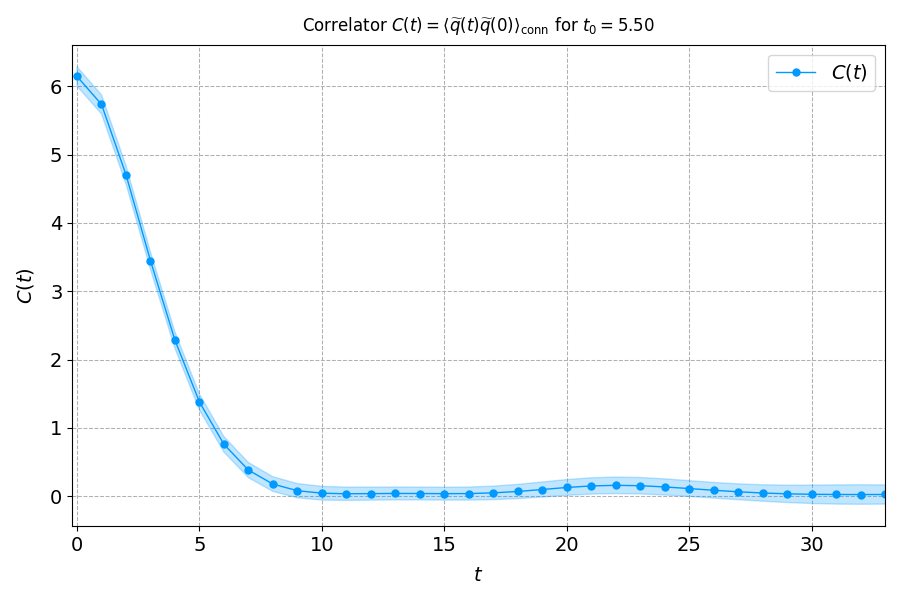

In [16]:
t0 = 5.50
i0 = int(np.around(t0 / (WF_step * eps_WF)))

Ct, dCt = Corr_QQ[i0].error()

fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.92)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.15)
plt.subplots_adjust(right  = 0.95)

fsize = 14

ax.set_title(rf"Correlator $C(t) = \langle \widetilde{{q}}(t) \widetilde{{q}}(0) \rangle_\mathrm{{conn}}$ for $t_0 = {t0:.2f}$", pad=10)
ax.set_ylabel(r"$C(t)$", labelpad=10, rotation=90, fontsize=fsize)
ax.set_xlabel(r'$t$', labelpad=8, fontsize=fsize)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlim([-0.2, T/2+1])
# plt.ylim([1e-2, 1e1])
# ax.set_yscale('log')
ax.grid(linestyle = '--', linewidth = 0.75)

std = 1.0
ax.plot(np.arange(T), Ct, label=r'$C(t)$', linestyle='-', marker='o' , markersize=5.0, color='#0099ff', linewidth=1.0)
ax.fill_between(np.arange(T), Ct + std * dCt, Ct - std * dCt, alpha=.25, color='#0099ff')

ax.legend(loc='best', fontsize=fsize)

fig.tight_layout()

#plt.savefig("tau_int.pdf")

In [17]:
#########################################
### Computation of sum_t C(t) and Chi ###
Tsym = T // 2

Chi = 2 * pyobs.cumsum(Corr_QQ[i0]) - pyobs.tile(Corr_QQ[i0][0], T) - pyobs.tile(Corr_QQ[i0][Tsym], T)   # C(0) + 2 sum_{i=1}^T C(i)
Q2_sum, dQ2_sum = Chi.error()
Chi /= V

t012_phys = pyobs.observable(description='(t_0,phys)^(1/2) fm')
t012_phys.create_from_cov('(t_0,phys)^(1/2)-Luscher', [0.176], [0.004**2])
const = 197.3 # MeV x fm ---> 1 = 197.3 MeV x fm

Tstop = 10 # Tsym
print(f" <Q^2> = {Chi[Tstop] * V}")
print(f" a^4 Chi = <Q^2> / (V / a^4) = {Chi[Tstop]}")
print(f" Chi x (t_0)^2 = a^4 Chi x (t_0/a^2)^2 = {Chi[Tstop] * (t0EClov ** 2)}")
print(f" Chi[fm^-4] = Chi x (t_0)^2 / (t_0,phys)^2 = {Chi[Tstop] * (t0EClov ** 2) / (t012_phys ** 4)}")
print(f" Chi^(1/4)[MeV] = {((Chi[Tstop] * (t0EClov ** 2)) ** 0.25) * const / t012_phys}")
#########################################

 <Q^2> = 44.1(2.2)

 a^4 Chi = <Q^2> / (V / a^4) = 0.0000210(11)

 Chi x (t_0)^2 = a^4 Chi x (t_0/a^2)^2 = 0.000636(33)

 Chi[fm^-4] = Chi x (t_0)^2 / (t_0,phys)^2 = 0.663(69)

 Chi^(1/4)[MeV] = 178.0(4.6)



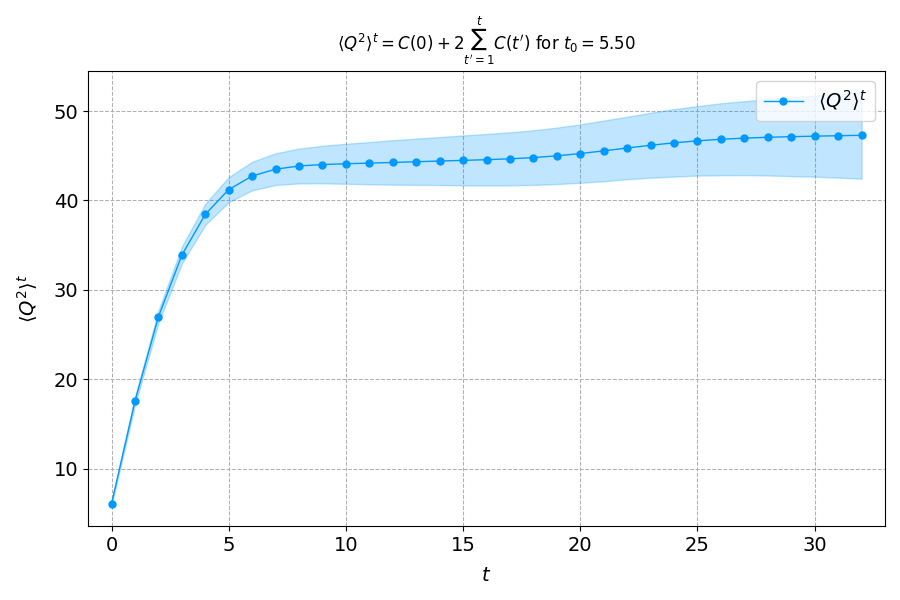

In [18]:
fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.92)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.15)
plt.subplots_adjust(right  = 0.95)

fsize = 14

ax.set_title(rf"$\langle Q^2 \rangle^t = C(0) + 2\sum_{{t'=1}}^t C(t')$ for $t_0 = {t0:.2f}$", pad=15)
ax.set_ylabel(r"$\langle Q^2 \rangle^t$", labelpad=10, rotation=90, fontsize=fsize)
ax.set_xlabel(r'$t$', labelpad=8, fontsize=fsize)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlim([-1, T/2+1])
#plt.ylim([1e-2, 1e1])
ax.grid(linestyle = '--', linewidth = 0.75)

std = 1.0
ax.plot(np.arange(Tsym+1), Q2_sum[:Tsym+1], label=r'$\langle Q^2 \rangle^t$', linestyle='-', marker='o' , markersize=5.0, color='#0099ff', linewidth=1.0)
ax.fill_between(np.arange(Tsym+1), Q2_sum[:Tsym+1] + std * dQ2_sum[:Tsym+1], Q2_sum[:Tsym+1] - std * dQ2_sum[:Tsym+1], alpha=.25, color='#0099ff')

ax.legend(loc='best', fontsize=fsize)

fig.tight_layout()

#plt.savefig("tau_int.pdf")

In [19]:
dEClov_t   = np.zeros((Nwf, Ncnfg, T))
dEPlaq_t   = np.zeros((Nwf, Ncnfg, T))
for i0 in range(Nwf):
    dEClov_t[i0,:,:] = EClov_t[i0].delta['Ensemble A:0'].delta.T
    dEPlaq_t[i0,:,:] = EPlaq_t[i0].delta['Ensemble A:0'].delta.T

dEdEClov_t = np.zeros((Nwf, Ncnfg, T))
dEdEPlaq_t = np.zeros((Nwf, Ncnfg, T))
for tp in range(T):
    dEdEClov_t[:,:,tp] = np.mean(dEClov_t * np.roll(dEClov_t, -tp, axis=2), axis=2)
    dEdEPlaq_t[:,:,tp] = np.mean(dEPlaq_t * np.roll(dEPlaq_t, -tp, axis=2), axis=2)

In [20]:
Corr_EEClov = []
Corr_EEPlaq = []
for i0 in range(Nwf):
    ### <EE>_Clov ###
    Corr_EEClov.append(pyobs.observable(description=f'<E(t)E(0)>_conn Clov for t_WF = {t_WF[i0]:.2f}'))
    Corr_EEClov[-1].create('Ensemble A', dEdEClov_t[i0,:,:].flatten(), shape=(T,))
    Corr_EEClov[-1] *= V/T           
    
    ### <EE>_Plaq ###
    Corr_EEPlaq.append(pyobs.observable(description=f'<E(t)E(0)>_conn Plaq for t_WF = {t_WF[i0]:.2f}'))
    Corr_EEPlaq[-1].create('Ensemble A', dEdEPlaq_t[i0,:,:].flatten(), shape=(T,))
    Corr_EEPlaq[-1] *= V/T
    
    print(f"t_Wf = {t_WF[i0]:.2f}  :  <E(t)E(0)>_conn Clov = {Corr_EEClov[-1]}                <E(t)E(0)>_conn Plaq = {Corr_EEPlaq[-1]}")

### save observables ###
print(f"\nSaving observables:\n")
if os.path.exists(f"PyObs/Corr_EEClov_tWF.pyobs"):
    os.remove(f"PyObs/Corr_EEClov_tWF.pyobs")
    pyobs.save(f"PyObs/Corr_EEClov_tWF.pyobs", pyobs.stack(Corr_EEClov))
else:
    pyobs.save(f"PyObs/Corr_EEClov_tWF.pyobs", pyobs.stack(Corr_EEClov))

if os.path.exists(f"PyObs/Corr_EEPlaq_tWF.pyobs"):
    os.remove(f"PyObs/Corr_EEPlaq_tWF.pyobs")
    pyobs.save(f"PyObs/Corr_EEPlaq_tWF.pyobs", pyobs.stack(Corr_EEPlaq))
else:
    pyobs.save(f"PyObs/Corr_EEPlaq_tWF.pyobs", pyobs.stack(Corr_EEPlaq))

t_Wf = 0.00  :  <E(t)E(0)>_conn Clov = 0.3396(11)	0.09166(91)	0.01631(85)	0.00404(86)	0.00112(84)	0.00161(82)	0.00050(80)	0.00038(80)	0.00057(84)	0.00062(80)	0.00068(81)	-0.00032(79)	-0.00082(79)	0.00076(82)	-0.00041(86)	0.00017(88)	0.00048(87)	-0.00033(79)	-0.00088(84)	-0.00128(84)	-0.00002(90)	0.00025(82)	-0.00100(83)	0.00066(85)	0.00116(79)	0.00093(83)	0.00161(79)	0.00154(79)	-0.00009(80)	-0.00040(79)	0.00012(86)	-0.00042(92)	-0.0008(12)	-0.00042(92)	0.00012(86)	-0.00040(79)	-0.00009(80)	0.00154(79)	0.00161(79)	0.00093(83)	0.00116(79)	0.00066(85)	-0.00100(83)	0.00025(82)	-0.00002(90)	-0.00128(84)	-0.00088(84)	-0.00033(79)	0.00048(87)	0.00017(88)	-0.00041(86)	0.00076(82)	-0.00082(79)	-0.00032(79)	0.00068(81)	0.00062(80)	0.00057(84)	0.00038(80)	0.00050(80)	0.00161(82)	0.00112(84)	0.00404(86)	0.01631(85)	0.09166(91)
                <E(t)E(0)>_conn Plaq = 15.565(48)	2.424(38)	0.336(37)	0.045(38)	-0.048(35)	0.020(36)	0.023(37)	-0.001(36)	-0.017(34)	0.002(37)	0.012(38)	0.017(36)	-0.009(38

## Autocorrelation functions calculations

In [21]:
### Compute autocorrelation functions for each <E_Clov>_t and <E_Plaq>_t ###
gammaEClov = []
gammaEPlaq = []
gammaQ     = []
gammaQ2    = []
if (len(EClov) == Nwf) and (len(EPlaq) == Nwf) \
    and (len(Q) == Nwf) and (len(Q2) == Nwf):
    for i0 in range(Nwf): 
        norm, gamma = EClov[i0].delta['Ensemble A:0'].gamma(Ncnfg, 0)
        gamma /= norm
        gammaEClov.append(gamma)
        norm, gamma = EPlaq[i0].delta['Ensemble A:0'].gamma(Ncnfg, 0)
        gamma /= norm
        gammaEPlaq.append(gamma)
        norm, gamma = Q[i0].delta['Ensemble A:0'].gamma(Ncnfg, 0)
        gamma /= norm
        gammaQ.append(gamma)
        norm, gamma = Q2[i0].delta['Ensemble A:0'].gamma(Ncnfg, 0)
        gamma /= norm
        gammaQ2.append(gamma)
else:
    print(f"Check observables shapes !")

norm, gamma_t0EClov = t0EClov.delta['Ensemble A:0'].gamma(Ncnfg, 0)
gamma_t0EClov /= norm 

norm, gamma_t0EPlaq = t0EPlaq.delta['Ensemble A:0'].gamma(Ncnfg, 0)
gamma_t0EPlaq /= norm 

norm, gamma_Chi_stop = Chi[Tstop].delta['Ensemble A:0'].gamma(Ncnfg, 0)
gamma_Chi_stop /= norm

gammaEClov     = np.array(gammaEClov)
gammaEPlaq     = np.array(gammaEPlaq)
gamma_Chi_stop = np.array(gamma_Chi_stop)
gammaQ         = np.array(gammaQ)
gammaQ2        = np.array(gammaQ2)

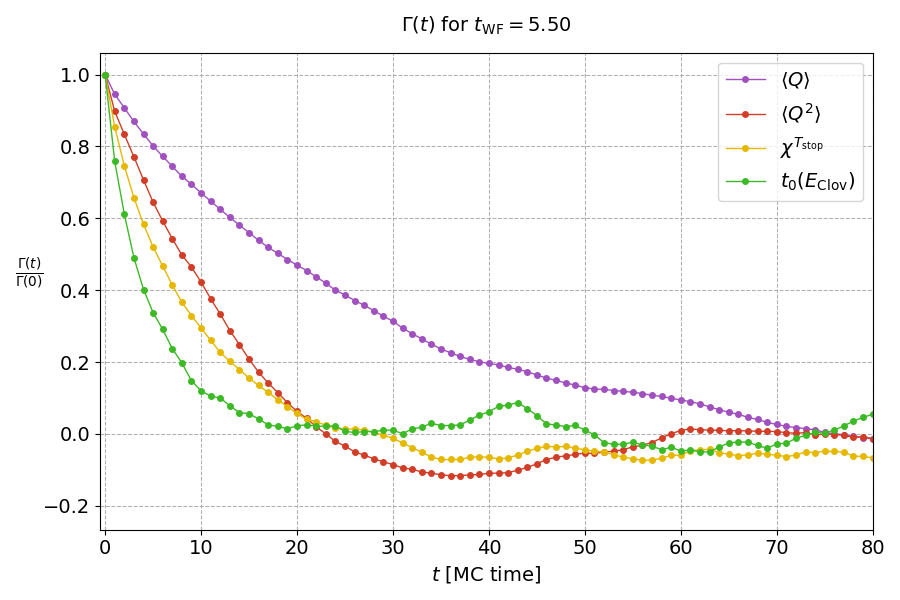

In [22]:
fig, ax = plt.subplots(figsize=(9, 6))

plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.05)
plt.subplots_adjust(left   = 0.05)
plt.subplots_adjust(right  = 0.95)
fsize = 14

tmax = Ncnfg // 4
t = 5.50
i = int(np.around(t / (eps_WF * WF_step))) 

plt.title(rf'$\Gamma(t)$ for $t_\mathrm{{WF}}={t:.2f}$', pad=15, fontsize=fsize)

# ax.plot(np.arange(tmax), gammaEClov[i,:tmax]/gammaEClov[i,0], color='#0099ff', \
#         marker='o',     linestyle='-',       linewidth='1.0', \
#         markersize=4.0,   label=rf'$\langle E_\mathrm{{Clov}} \rangle$')
# ax.plot(np.arange(tmax), gammaEPlaq[i,:tmax]/gammaEPlaq[i,0], color='#ff9900', \
#         marker='o',     linestyle='-',       linewidth='1.0', \
#         markersize=4.0,   label=rf'$\langle E_\mathrm{{Plaq}} \rangle$')
ax.plot(np.arange(tmax), gammaQ[i,:tmax]/gammaQ[i,0], color='#a151bf', \
        marker='o',     linestyle='-',       linewidth='1.0', \
        markersize=4.0,   label=rf'$\langle Q \rangle$')
ax.plot(np.arange(tmax), gammaQ2[i,:tmax]/gammaQ2[i,0], color='#d13e27', \
        marker='o',     linestyle='-',       linewidth='1.0', \
        markersize=4.0,   label=rf'$\langle Q^2 \rangle$')
ax.plot(np.arange(tmax), gamma_Chi_stop[:tmax]/gamma_Chi_stop[0], color='#e6b800', \
        marker='o',     linestyle='-',       linewidth='1.0', \
        markersize=4.0,   label=rf'$\chi^{{T_\mathrm{{stop}}}}$')
ax.plot(np.arange(tmax), gamma_t0EClov[:tmax]/gamma_t0EClov[0], color='#3cba25', \
        marker='o',     linestyle='-',       linewidth='1.0', \
        markersize=4.0,   label=rf'$t_0(E_\mathrm{{Clov}})$')
ax.set_xlabel(r'$t$ [MC time]', fontsize=fsize)
ax.set_ylabel(r'$\frac{\Gamma(t)}{\Gamma(0)}$', rotation=0, labelpad=10, fontsize=fsize)
ax.legend(loc='best', fontsize=fsize)


plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.xlim([-0.5, 80])
#plt.ylim([1e-2, 1e1])
#ax.set_yscale('log', base=10)
#ax.set_xscale('log', base=10)
ax.grid(linestyle = '--', linewidth = 0.75)

fig.tight_layout()

## Bounding Method application

In [23]:
### Bounding Method ###
t0 = 5.50
i0 = int(np.around(t0 / (eps_WF * WF_step)))
tau0 = Q[i0].tauint()['Ensemble A'][0][0]
print(f"\n tau_slow for bounding = {tau0:.2f}, which is {int(tau0 * tauMD * MC_step)} MDU\n")

# Tmax = 40
# for t in range(Tmax):
#    # print(f" t0     :    tau_eff(W={t}) = {1.0 / np.log(gamma_t0EClov[t] / gamma_t0EClov[t+1]):.3f},")
#    print(f" Q      :    tau_eff(W={t}) = {1.0 / np.log(gammaQ[i0, t] / gammaQ[i0, t+1]):.3f},")
#    # print(f" Q^2   :    tau_eff(W={t}) = {1.0 / np.log(gammaQ2[i0, t] / gammaQ2[i0, t+1]):.3f},")
# print("\n")


 tau_slow for bounding = 22.67, which is 453 MDU



In [24]:
W_bnd_t0  = Bounding_Method.bounding(gamma_t0EClov,  4*tau0, Ncnfg, info=False)
W_bnd_Q   = Bounding_Method.bounding(gammaQ[i0, :],  4*tau0, Ncnfg, info=False)
W_bnd_Q2  = Bounding_Method.bounding(gammaQ2[i0, :], 4*tau0, Ncnfg, info=False)
W_bnd_Chi = Bounding_Method.bounding(gamma_Chi_stop, 4*tau0, Ncnfg, info=False)

print(f"\n W_bnd_t0   =  {W_bnd_t0}\n W_bnd_Q    =  {W_bnd_Q}\n W_bnd_Q2   =  {W_bnd_Q2}\n W_bnd_Chi  =  {W_bnd_Chi}\n")
print(f" t0         :  err(W={W_bnd_t0}) = {np.sqrt(Bounding_Method.Cbar_W(gamma_t0EClov, W_bnd_t0) / Ncnfg)}")
print(f" Q          :  err(W={W_bnd_Q}) = {np.sqrt(Bounding_Method.Cbar_W(gammaQ[i0, :], W_bnd_Q) / Ncnfg)}")
print(f" Q2         :  err(W={W_bnd_Q2}) = {np.sqrt(Bounding_Method.Cbar_W(gammaQ2[i0, :], W_bnd_Q2) / Ncnfg)}")
print(f" Chi_stop   :  err(W={W_bnd_Chi}) = {np.sqrt(Bounding_Method.Cbar_W(gamma_Chi_stop, W_bnd_Chi) / Ncnfg)}\n")


 W_bnd_t0   =  26
 W_bnd_Q    =  68
 W_bnd_Q2   =  23
 W_bnd_Chi  =  28

 t0         :  err(W=26) = 0.007067676922194718
 Q          :  err(W=68) = 0.8562899848273681
 Q2         :  err(W=23) = 5.273264398423832
 Chi_stop   :  err(W=28) = 1.0968793411471618e-06



In [26]:
# e, de = t0EClov.error(plot=True)
# print(e, de)
# e, de = Q[i0].error(plot=True)
# print(e, de)
# e, de = Q2[i0].error(plot=True)
# print(e, de)
# e, de = Chi[Tstop].error(plot=True)
# print(e, de)

No handles with labels found to put in legend.


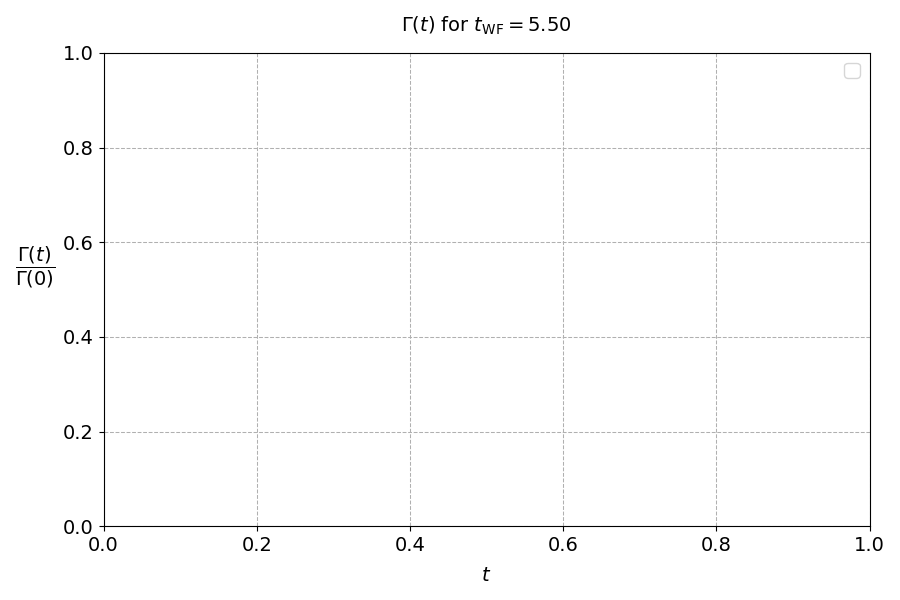

In [29]:
### Bounding plots of W_bnd for the Gammas above ###

fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.12)
plt.subplots_adjust(right  = 0.95)

### W results: ###
W_wff_t0, W_wff_Q, W_wff_Q2, W_wff_Chi = 27, 94, 39, 37

fsize = 14
box = dict(boxstyle="round", color='#d9d9d9')

tmax = Ncnfg // 4
t = 5.50
i = int(np.around(t / (eps_WF * WF_step))) 

plt.title(rf'$\Gamma(t)$ for $t_\mathrm{{WF}}={t:.2f}$', pad=15, fontsize=fsize)

ax.set_ylabel(r"$\dfrac{\Gamma(t)}{\Gamma(0)}$", labelpad=20, rotation=0, fontsize=fsize)
ax.set_xlabel(r'$t$', labelpad=8, fontsize=fsize)



# ### t0(E_clov) ###
# ax.plot(np.arange(tmax), gamma_t0EClov[:tmax]/gamma_t0EClov[0], color='#3cba25', \
#         marker='o',     linestyle='-',       linewidth='1.5', \
#         markersize=5.0,   label=rf'$t_0(E_\mathrm{{Clov}})$')
# ax.scatter(W_bnd_t0, gamma_t0EClov[W_bnd_t0]/gamma_t0EClov[0], color='black', marker='D', s=50)
# ax.vlines(x = W_bnd_t0, ymin = gamma_t0EClov[W_bnd_t0]/gamma_t0EClov[0], ymax = gamma_t0EClov[W_bnd_t0]/gamma_t0EClov[0] + 0.15, colors = 'black', linewidth=1.5)
# ax.annotate(rf"$W_\mathrm{{bnd}} = {W_bnd_t0}$", (W_bnd_t0, 0.40), xytext=(W_bnd_t0-1.3, gamma_t0EClov[W_bnd_t0]/gamma_t0EClov[0] + 0.15), ha='center', bbox=box, fontsize=fsize)
# ax.scatter(W_wff_t0, gamma_t0EClov[W_wff_t0]/gamma_t0EClov[0], color='black', marker='D', s=50)
# ax.vlines(x = W_wff_t0, ymin = gamma_t0EClov[W_wff_t0]/gamma_t0EClov[0], ymax = gamma_t0EClov[W_wff_t0]/gamma_t0EClov[0] + 0.15, colors = 'black', linewidth=1.5)
# ax.annotate(rf"$W_\mathrm{{wff}} = {W_wff_t0}$", (W_wff_t0, 0.40), xytext=(W_wff_t0+1.3, gamma_t0EClov[W_wff_t0]/gamma_t0EClov[0] + 0.15), ha='center', bbox=box, fontsize=fsize)
# plt.xlim([-0.2, max(W_wff_t0, W_bnd_t0)+4])



# ### Q ###
# ax.plot(np.arange(tmax), gammaQ[i,:tmax]/gammaQ[i,0], color='#a151bf', \
#         marker='o',     linestyle='-',       linewidth='1.0', \
#         markersize=4.0,   label=rf'$\langle Q \rangle$')
# ax.scatter(W_bnd_Q, gammaQ[i,W_bnd_Q]/gammaQ[i,0], color='black', marker='D', s=50)
# ax.vlines(x = W_bnd_Q, ymin = gammaQ[i,W_bnd_Q]/gammaQ[i,0], ymax = gammaQ[i,W_bnd_Q]/gammaQ[i,0] + 0.15, colors = 'black', linewidth=1.5)
# ax.annotate(rf"$W_\mathrm{{bnd}} = {W_bnd_Q}$", (W_bnd_Q, 0.40), xytext=(W_bnd_Q, gammaQ[i,W_bnd_Q]/gammaQ[i,0] + 0.15), ha='center', bbox=box, fontsize=fsize)
# ax.scatter(W_wff_Q, gammaQ[i,W_wff_Q]/gammaQ[i,0], color='black', marker='D', s=50)
# ax.vlines(x = W_wff_Q, ymin = gammaQ[i,W_wff_Q]/gammaQ[i,0], ymax = gammaQ[i,W_wff_Q]/gammaQ[i,0] + 0.15, colors = 'black', linewidth=1.5)
# ax.annotate(rf"$W_\mathrm{{wff}} = {W_wff_Q}$", (W_wff_Q, 0.40), xytext=(W_wff_Q, gammaQ[i,W_wff_Q]/gammaQ[i,0] + 0.15), ha='center', bbox=box, fontsize=fsize)
# plt.xlim([-0.75, max(W_wff_Q, W_bnd_Q) + 10])
# plt.ylim([-0.1, 1.025])



# ### Q^2 ###
# ax.plot(np.arange(tmax), gammaQ2[i,:tmax]/gammaQ2[i,0], color='#d13e27', \
#         marker='o',     linestyle='-',       linewidth='1.0', \
#         markersize=4.0,   label=rf'$\langle Q^2 \rangle$')
# ax.scatter(W_bnd_Q2, gammaQ2[i,W_bnd_Q2]/gammaQ2[i,0], color='black', marker='D', s=50)
# ax.vlines(x = W_bnd_Q2, ymin = gammaQ2[i,W_bnd_Q2]/gammaQ2[i,0], ymax = gammaQ2[i,W_bnd_Q2]/gammaQ2[i,0] + 0.15, colors = 'black', linewidth=1.5)
# ax.annotate(rf"$W_\mathrm{{bnd}} = {W_bnd_Q2}$", (W_bnd_Q2, 0.40), xytext=(W_bnd_Q2, gammaQ2[i,W_bnd_Q2]/gammaQ2[i,0] + 0.15), ha='center', bbox=box, fontsize=fsize)
# ax.scatter(W_wff_Q2, gammaQ2[i,W_wff_Q2]/gammaQ2[i,0], color='black', marker='D', s=50)
# ax.vlines(x = W_wff_Q2, ymin = gammaQ2[i,W_wff_Q2]/gammaQ2[i,0], ymax = gammaQ2[i,W_wff_Q2]/gammaQ2[i,0] + 0.15, colors = 'black', linewidth=1.5)
# ax.annotate(rf"$W_\mathrm{{wff}} = {W_wff_Q2}$", (W_wff_Q2, 0.40), xytext=(W_wff_Q2, gammaQ2[i,W_wff_Q2]/gammaQ2[i,0] + 0.15), ha='center', bbox=box, fontsize=fsize)
# plt.xlim([-0.75, max(W_wff_Q2, W_bnd_Q2)+10])
# # plt.ylim([-0.1, 1.025])



# ### Chi^Tstop ###
# ax.plot(np.arange(tmax), gamma_Chi_stop[:tmax]/gamma_Chi_stop[0], color='#e6b800', \
#         marker='o',     linestyle='-',       linewidth='1.0', \
#         markersize=4.0,   label=rf'$\chi^{{T_\mathrm{{stop}}}}$')
# ax.scatter(W_bnd_Chi, gamma_Chi_stop[W_bnd_Chi]/gamma_Chi_stop[0], color='black', marker='D', s=50)
# ax.vlines(x = W_bnd_Chi, ymin = gamma_Chi_stop[W_bnd_Chi]/gamma_Chi_stop[0], ymax = gamma_Chi_stop[W_bnd_Chi]/gamma_Chi_stop[0] + 0.15, colors = 'black', linewidth=1.5)
# ax.annotate(rf"$W_\mathrm{{bnd}} = {W_bnd_Chi}$", (W_bnd_Chi, 0.40), xytext=(W_bnd_Chi-2, gamma_Chi_stop[W_bnd_Chi]/gamma_Chi_stop[0] + 0.15), ha='center', bbox=box, fontsize=fsize)
# ax.scatter(W_wff_Chi, gamma_Chi_stop[W_wff_Chi]/gamma_Chi_stop[0], color='black', marker='D', s=50)
# ax.vlines(x = W_wff_Chi, ymin = gamma_Chi_stop[W_wff_Chi]/gamma_Chi_stop[0], ymax = gamma_Chi_stop[W_wff_Chi]/gamma_Chi_stop[0] + 0.15, colors = 'black', linewidth=1.5)
# ax.annotate(rf"$W_\mathrm{{wff}} = {W_wff_Chi}$", (W_wff_Chi, 0.40), xytext=(W_wff_Chi+2, gamma_Chi_stop[W_wff_Chi]/gamma_Chi_stop[0] + 0.15), ha='center', bbox=box, fontsize=fsize)
# plt.xlim([-0.75, max(W_wff_Q2, W_bnd_Q2)+10])
# # plt.ylim([-0.1, 1.025])


plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
#plt.ylim([1e-2, 1e1])
ax.grid(linestyle = '--', linewidth = 0.75)

ax.legend(loc='best', fontsize=fsize)
fig.tight_layout()
#plt.savefig('t0E.pdf')